In [2]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta  
import threading 

from psql_functions import execQuery
from miss_data import add_missing_dates, add_missing_counts
from make_plots import dict_error_plot_epsilons, dict_error_plot_n


In [3]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)

counts = [(count[0]) for count in result]

all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)


Executed query and closed connection.
Executed query and closed connection.


In [6]:
class central_flat:
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere
        Parameters:
        epsilon (float): The epsilon for differintial privacy
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructure
        """
        
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        
        if len(dates) < (dates[-1]-dates[0]).days:
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.noisy_counts = self.__process(self.all_counts)
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = old_dates[0]
        end_date = old_dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]

    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.all_dates))
        for i, date in enumerate(self.all_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts

    def __process(self, counts):
        N = len(counts)
        laplaces = laplace(scale=1/self.epsilon).rvs(N)
        noise_counts = counts + laplaces
                
        return noise_counts
    
    def answer(self, dates):
        """Calculates the differintial private answear

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
        if (len(dates) < 2):
            #There is only one date
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()

            idx = self.idx_dict[date_obj_0]
            noise_count = self.noisy_counts[idx]
            return noise_count
            
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()

            noise_sum = np.sum(self.noisy_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return noise_sum
    
    def real_answer(self, dates):
        """Calculates the real answer to a range query

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The real range count
        """
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.all_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            sum_ = np.sum(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_ 




1444.0


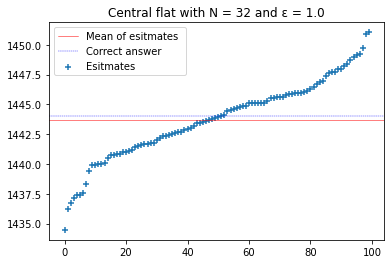

"\n#20\n#2014-01-12, 2014-01-31\nquery_dates = ('2014-01-27','2014-02-01')  \nepsilon = 1.\nnumber_of_queries = 100 \nN = 32\na = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')\n\n#24\nquery_dates = ('2014-01-27','2014-02-01')   \n#range_dates = ('2014-01-2','2014-01-25')    \n\nepsilon = 1.\nnumber_of_queries = 100 \nN = 32\na = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')\n\n#Whole\nrange_dates = ('2014-01-2','2014-02-1')    \n\nepsilon = 1.\nnumber_of_queries = 50 \nN = 32\na = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')\n"

In [9]:
def plot_estimates_flat(number_of_qurries, N, model, epsilon, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    #print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()
    print(correct_answer)
    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.axhline(current_model.var,linewidth=.4, color='g', linestyle = '--', label="VAR")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Central flat with N = {N} and \u03B5 = {epsilon}')
    plt.savefig(plot_name,dpi=300,bbox_inches='tight')
    plt.show()
    
    return answers
    
    

range_dates = ('2014-01-27','2014-02-01')

epsilon = 1.
number_of_queries = 100 
N = 32
a = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')
"""
#20
#2014-01-12, 2014-01-31
query_dates = ('2014-01-27','2014-02-01')  
epsilon = 1.
number_of_queries = 100 
N = 32
a = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')

#24
query_dates = ('2014-01-27','2014-02-01')   
#range_dates = ('2014-01-2','2014-01-25')    

epsilon = 1.
number_of_queries = 100 
N = 32
a = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')

#Whole
range_dates = ('2014-01-2','2014-02-1')    

epsilon = 1.
number_of_queries = 50 
N = 32
a = plot_estimates_flat(number_of_queries, N, central_flat, epsilon, all_dates, all_counts, range_dates, '123.png')
"""